In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
from MontePython import monte_python

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from glob import glob
from os.path import join
from skimage.measure import regionprops, regionprops_table
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

In [3]:
### NWS Reflectivity Colors (courtesy MetPy library):
c5 =  (0.0,                 0.9254901960784314, 0.9254901960784314)
c10 = (0.00392156862745098, 0.6274509803921569, 0.9647058823529412)
c15 = (0.0,                 0.0,                0.9647058823529412)
c20 = (0.0,                 1.0,                0.0)
c25 = (0.0,                 0.7843137254901961, 0.0)
c30 = (0.0,                 0.5647058823529412, 0.0)
c35 = (1.0,                 1.0,                0.0)
c40 = (0.9058823529411765,  0.7529411764705882, 0.0)
c45 = (1.0,                 0.5647058823529412, 0.0)
c50 = (1.0,                 0.0,                0.0)
c55 = (0.8392156862745098,  0.0,                0.0)
c60 = (0.7529411764705882,  0.0,                0.0)
c65 = (1.0,                 0.0,                1.0)
c70 = (0.6,                 0.3333333333333333, 0.788235294117647)
c75 = (0.0,                 0.0,                0.0) 

nws_dz_cmap = matplotlib.colors.ListedColormap([c20, c25, c30, c35, c40, c45, 
                 c50, c55, c60, c65, c70])
dz_levels_nws = np.arange(20.0,80.,5.)

In [4]:
date = '20210527'

basePath = f'/work/mflora/SummaryFiles/{date}/0000/'
files = glob(join(basePath, 'wofs_ENS_*'))
files.sort()
#files = files[:12]

In [5]:
files

['/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_00_20210528_0000_0000.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_01_20210528_0000_0005.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_02_20210528_0000_0010.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_03_20210528_0000_0015.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_04_20210528_0000_0020.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_05_20210528_0000_0025.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_06_20210528_0000_0030.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_07_20210528_0000_0035.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_08_20210528_0000_0040.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_09_20210528_0000_0045.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_10_20210528_0000_0050.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_11_20210528_0000_0055.nc',
 '/work/mflora/SummaryFiles/20210527/0000/wofs_ENS_12_20210528_0

In [6]:
qcer = monte_python.QualityControler()
all_labels = np.zeros((len(files), 300, 300), dtype=np.int8)
z_set = np.zeros((len(files), 300, 300))
dbz_qc_params = [
            ("min_area", 15),
            ("merge_thresh", 3),
            ("max_thresh", (44.93, 100)),
        ]

for i, f in enumerate(files):
    ds = xr.open_dataset(f, decode_times=False)
    dbz = ds['comp_dz'].values[0,:,:]
    
    ds.close()
    
    storm_labels, object_props = monte_python.label(  input_data = dbz, 
                       method ='single_threshold', 
                       return_object_properties=True, 
                       params = {'bdry_thresh' : 43.0},  
                       )
    # QCing the labels
    storm_labels,_ = qcer.quality_control(dbz, storm_labels, 
                                          object_props, dbz_qc_params,)
    
    all_labels[i,:,:] = storm_labels 
    z_set[i,:,:] = dbz 

In [7]:
# Track the objects in time. 
tracker = monte_python.ObjectTracker(percent_overlap=0.0, mend_tracks=True)
tracked_objects = tracker.track(all_labels)

In [8]:
class TrackAnimator:
    """
    Creates an animation of the tracks including a label over the centroid and
    a line showing the track. 
    """
    def __init__(self, tracked_objects, dataset):
        
        self.tracked_objects = tracked_objects
        self.dataset=dataset
        
        self.object_props = [regionprops(tracks, data) for tracks, data in zip(tracked_objects, tracked_objects)]
        
        properties = ['label', 'centroid']
        objects_df = [pd.DataFrame(regionprops_table(tracks, data, properties)) 
              for tracks, data in zip(tracked_objects, tracked_objects)]
        
        self.x_cent, self.y_cent = self.get_track_path(objects_df, tracked_objects)
        
        self.x, self.y = np.meshgrid(np.arange(300), np.arange(300))
        
    
    def create_initial_frame(self):
        # Animate the Figure. 
        fig, ax = plt.subplots(dpi=300)
        
        # Animate the Figure. 
        cont = ax.contourf(self.x, self.y, self.dataset[0],
                   cmap=nws_dz_cmap, levels=dz_levels_nws, )

        ax.contourf(self.x, self.y, np.ma.masked_where(self.tracked_objects[0]<1, self.tracked_objects[0]),
                    cmap = 'tab20b', alpha=0.6)
        
        self.plot_track(ax, self.y_cent, self.x_cent, 0)
        self.label_centroid(ax, self.object_props[0])
        fig.colorbar(cont, label='Reflectivity')
    
        return fig, ax 
    
    
    def animate(self, i):
        global cont
        z = self.dataset[i]
        tracks = self.tracked_objects[i,:,:]
        props = self.object_props[i]
        ax.clear()
        
        cont = ax.contourf(self.x,self.y, z, 
                       cmap=nws_dz_cmap, levels=dz_levels_nws,)
    
        ax.contourf(self.x, self.y, np.ma.masked_where(tracks<1, tracks), cmap = 'tab20b', alpha=0.6)
        self.label_centroid(ax, props)
        self.plot_track(ax, self.y_cent, self.x_cent, i)
        
        return cont

    
    def label_centroid(self, ax, object_props):
        """Place object label on object's centroid"""
        for region in object_props:
            x_cent,y_cent = region.centroid
            x_cent=int(x_cent)
            y_cent=int(y_cent)
            xx, yy = self.x[x_cent,y_cent], self.y[x_cent,y_cent]
            fontsize = 6.5 if region.label >= 10 else 8
            ax.text(xx,yy,
                    region.label,
                    fontsize=fontsize,
                    ha='center',
                    va='center',
                    color = 'k'
                    )
    
    def get_centroid(self, df, label):
        try:
            df=df.loc[df['label'] == label]
            x_cent, y_cent = df['centroid-0'], df['centroid-1']
            x_cent=int(x_cent)
            y_cent=int(y_cent)
        except:
            return np.nan, np.nan
    
        return x_cent, y_cent 
    
    def get_track_path(self, object_props, tracked_objects):
        """ Create track path. """
        unique_labels = np.unique(tracked_objects)[1:]
        centroid_x = {l : [] for l in unique_labels}
        centroid_y = {l : [] for l in unique_labels}
    
    
        for df in object_props:
            for label in unique_labels:
                x,y = self.get_centroid(df, label)
                centroid_x[label].append(x)
                centroid_y[label].append(y)
    
        return centroid_x, centroid_y

    def plot_track(self, ax, x_cent, y_cent, ind): 
        labels = x_cent.keys()
        for l in labels:
            xs,ys = x_cent[l], y_cent[l]
            ax.plot(xs[:ind], ys[:ind], lw='0.5')


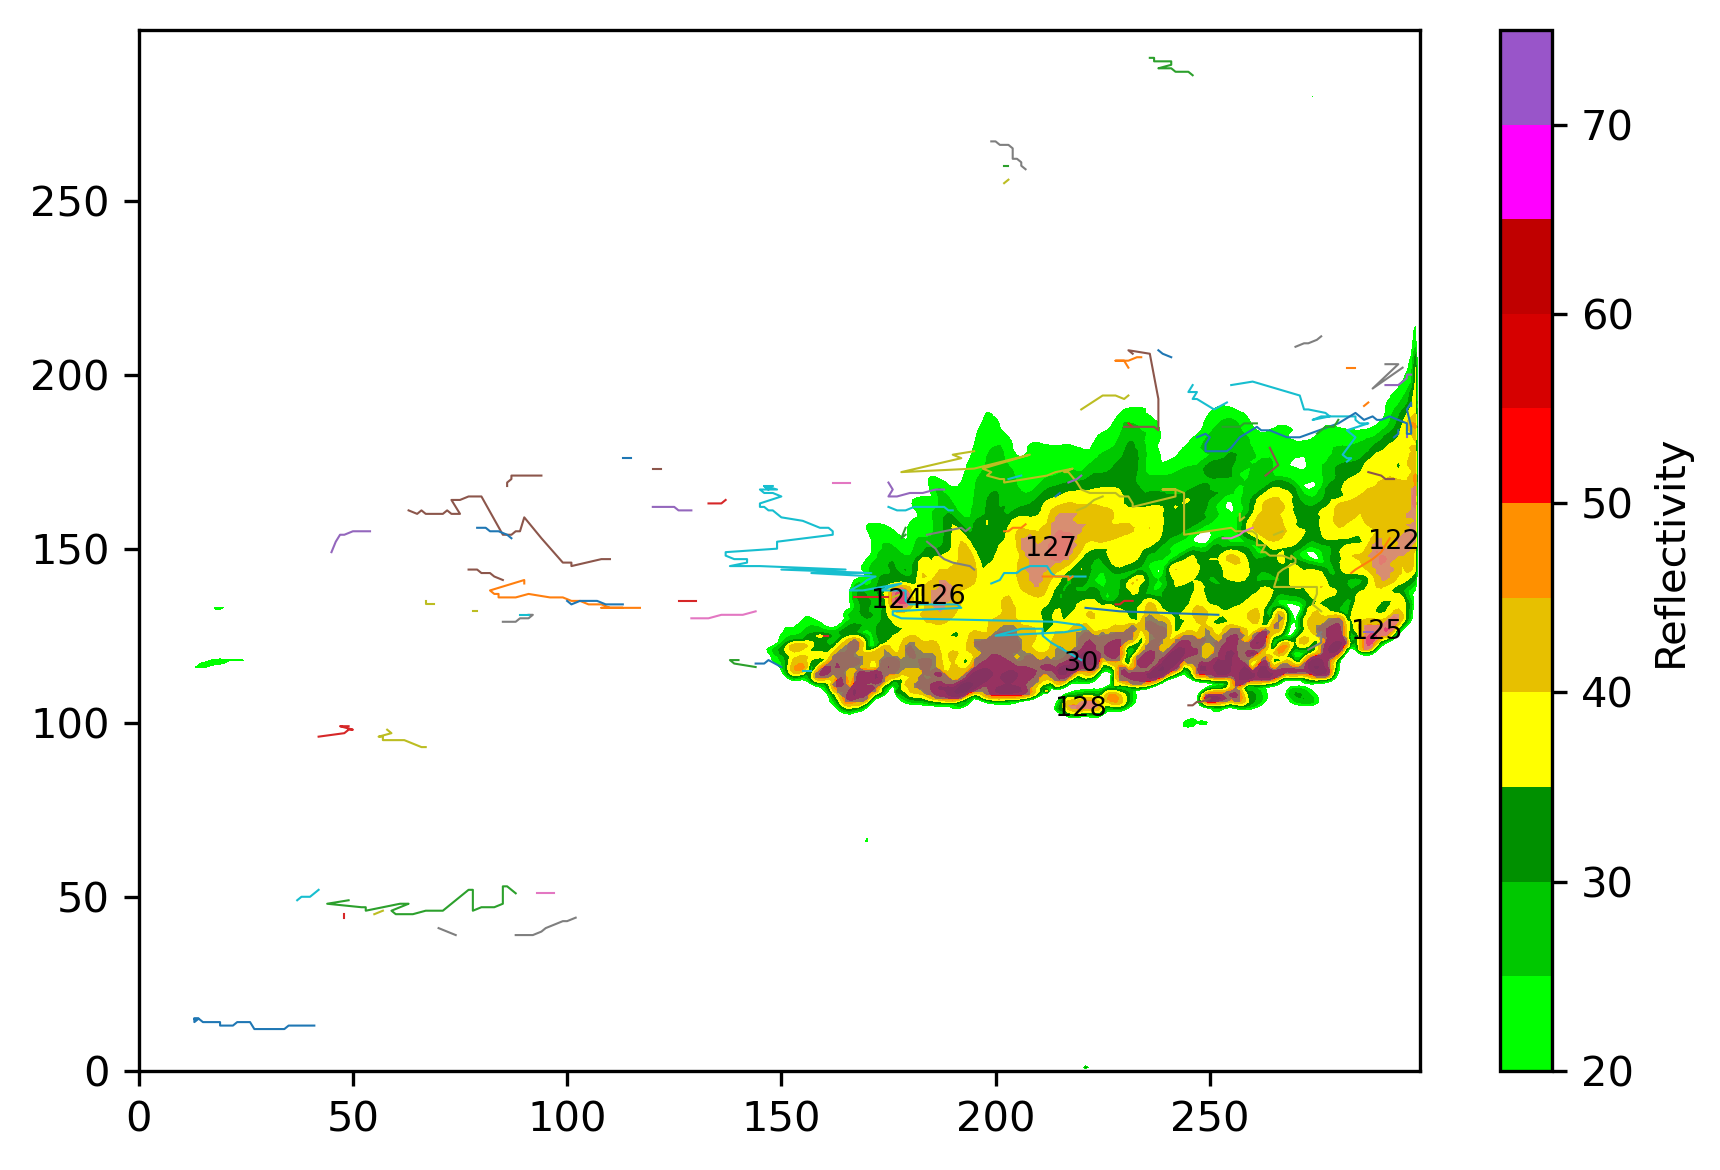

In [9]:
# Animate the Figure. 
animator = TrackAnimator(tracked_objects, z_set)
fig, ax = animator.create_initial_frame()

# call the animator. blit=True means only re-draw the parts that have changed.
plt.tight_layout()
anim = FuncAnimation(fig, animator.animate, frames=len(z_set), interval=40, repeat=True, blit=False)
HTML(anim.to_jshtml())
anim.save(f'tune_object_{date}.gif', writer='pillow', fps=5)

In [10]:
tracker.trackprops

,labels,duration,length
0,1,35,52
1,2,1,0
2,3,30,339
3,4,7,52
4,5,8,27
...,...,...,...
123,124,5,27
124,125,3,5
125,126,2,13
126,127,2,5


In [11]:
tracks = np.copy(tracked_objects)
tracks[tracked_objects!=30] = 0
one_object = np.max(tracks, axis=0)

x = range(len(one_object))
x,y = np.meshgrid(x,x)



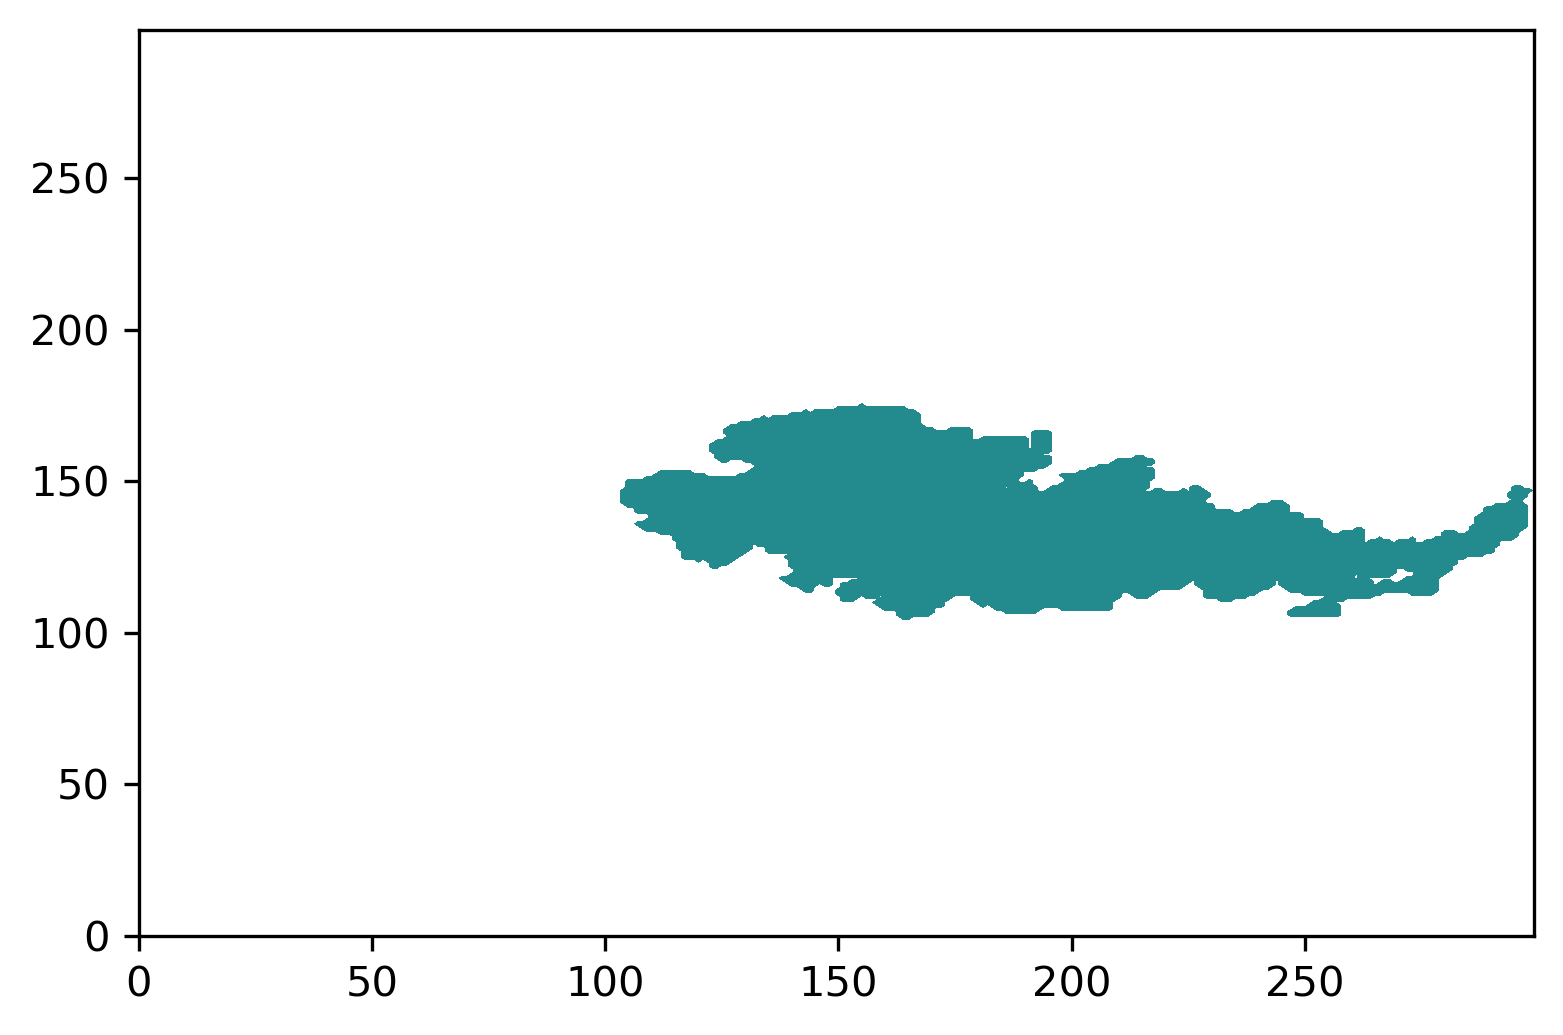

In [14]:
plt.figure(dpi=300)
plt.contourf(x,y,one_object, levels=[10,30,31])